# 3 A PAT application
> In 2004, the Food and Drug Administration (FDA) released a guidance to encourage innovation in pharmaceutical development, manufacturing and quality assurance. The framework, called Process Analytical Technology (PAT), combines MultiVariate Data Analysis (MVDA), Design of Experiments (DoE) and process analytical chemistry methods such as UV, IR, NIR,
NMR (fast, precise, online and preferably non-invasive methods).


>Here, we use PCA and PLS, two classic MVDA approaches to assess the feasibility of using NIR to measure a critical quality component of a wood product, the composition of wood ber. In the first part, we will perform unsupervised data exploration with PCA. In the second part, we will run PLS, a supervised learning algorithm, to quantify the outputs of interest (i.e. wood composition).

##3.1 Description of the process
>Sawdust from industrial sawing of birch, pine and spruce is mixed at different ratios to manufacture a final wood product. The NIR spectra for 15 samples of known composition of the three different types of wood were used to train the model. Each sample was tested twice (resulting in 30 rows) and NIR spectra data was collected in the range between 1100-2300 nm. Thus, the input X-table is (30 rows)x(1201 columns) and the output Y-table is (30 rows)x(3 columns), where the three outputs/compositions are recorded as percent proportion of spruce, pine and birch. Data for the training of the model are in the file **sawdust train.xlsx**


>In order to assess the accuracy of the model developed, we have a test data set of NIR data (X) and proportions Y different than the training data set. The test data set is not "seen" by the model during training. The proportions in the test set were selected to be different than those in the train set to assess the predictive power of the model under realistic conditions. There were 12 samples measured twice, therefore the number of rows in the X and Y-tables is 24. The test data are in the file **sawdust pred.xlsx**

##3.2 Task 1: Unsupervised learning, PCA of NIR data
> A. Generate the plot of all the training set raw NIR data.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

In [13]:
train = pd.read_excel('sawdust_train.xlsx')
train.head()

,Primary ID,OBSNAM,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,w1108,w1109,w1110,w1111,w1112,w1113,w1114,w1115,w1116,w1117,w1118,w1119,w1120,w1121,w1122,w1123,w1124,w1125,w1126,w1127,w1128,w1129,w1130,w1131,w1132,w1133,w1134,w1135,w1136,w1137,...,w2264,w2265,w2266,w2267,w2268,w2269,w2270,w2271,w2272,w2273,w2274,w2275,w2276,w2277,w2278,w2279,w2280,w2281,w2282,w2283,w2284,w2285,w2286,w2287,w2288,w2289,w2290,w2291,w2292,w2293,w2294,w2295,w2296,w2297,w2298,w2299,w2300,Spruce,Pine,Birch
0,1,02a,1.83444,1.83416,1.83350,1.83237,1.83084,1.82910,1.82742,1.82611,1.82516,1.82452,1.82407,1.82372,1.82334,1.82283,1.82213,1.82134,1.82036,1.81930,1.81814,1.81696,1.81579,1.81471,1.81368,1.81269,1.81162,1.81055,1.80940,1.80812,1.80669,1.80520,1.80365,1.80204,1.80033,1.79850,1.79654,1.79447,1.79224,1.78987,...,0.474785,0.475201,0.475893,0.477067,0.478534,0.480241,0.482001,0.483780,0.485739,0.488090,0.490816,0.493888,0.496992,0.500208,0.503312,0.506305,0.509129,0.511941,0.514845,0.518192,0.521982,0.526057,0.530565,0.535400,0.540498,0.545399,0.550011,0.554586,0.559044,0.563587,0.568213,0.572867,0.577625,0.582679,0.587850,0.593058,0.598025,0.00,100.00,0.00
1,2,02b,1.82992,1.82965,1.82902,1.82800,1.82667,1.82501,1.82347,1.82225,1.82135,1.82070,1.82019,1.81970,1.81914,1.81827,1.81732,1.81630,1.81521,1.81415,1.81310,1.81212,1.81122,1.81030,1.80937,1.80840,1.80737,1.80635,1.80527,1.80412,1.80288,1.80141,1.79986,1.79817,1.79645,1.79467,1.79280,1.79087,1.78882,1.78641,...,0.473774,0.474213,0.474748,0.475621,0.476784,0.478267,0.479963,0.481736,0.483618,0.485618,0.487620,0.489659,0.491748,0.494232,0.497150,0.500430,0.503719,0.507047,0.510351,0.513900,0.517821,0.521983,0.526621,0.531626,0.536929,0.542099,0.547000,0.551910,0.556829,0.561744,0.566549,0.571178,0.575774,0.580471,0.585226,0.589929,0.594470,0.00,100.00,0.00
2,5,15a,1.84602,1.84569,1.84522,1.84431,1.84311,1.84172,1.84035,1.83918,1.83834,1.83773,1.83732,1.83694,1.83661,1.83620,1.83573,1.83525,1.83471,1.83405,1.83323,1.83232,1.83131,1.83032,1.82927,1.82825,1.82717,1.82610,1.82499,1.82369,1.82216,1.82053,1.81872,1.81676,1.81466,1.81245,1.81011,1.80754,1.80482,1.80191,...,0.455464,0.456610,0.458070,0.459900,0.461908,0.463893,0.465765,0.467519,0.469300,0.471321,0.473713,0.476485,0.479494,0.482882,0.486578,0.490449,0.494293,0.498253,0.502440,0.507076,0.511987,0.516789,0.521732,0.526741,0.531986,0.537183,0.542190,0.547198,0.552090,0.557003,0.561938,0.566829,0.571796,0.577128,0.582482,0.587653,0.592419,33.33,33.33,33.33
3,6,15b,1.84556,1.84514,1.84444,1.84340,1.84206,1.84054,1.83912,1.83795,1.83714,1.83658,1.83626,1.83604,1.83578,1.83540,1.83483,1.83414,1.83330,1.83237,1.83140,1.83043,1.82947,1.82862,1.82778,1.82696,1.82604,1.82503,1.82387,1.82256,1.82106,1.81939,1.81758,1.81561,1.81348,1.81119,1.80868,1.80613,1.80346,1.80061,...,0.457400,0.458493,0.459469,0.460552,0.461734,0.463181,0.464938,0.467002,0.469513,0.472629,0.476135,0.479899,0.483502,0.487067,0.490531,0.493908,0.497135,0.500304,0.503643,0.507464,0.511839,0.516445,0.521344,0.526491,0.531965,0.537382,0.542657,0.547984,0.553266,0.558515,0.563561,0.568268,0.572794,0.577536,0.582409,0.587451,0.592277,33.33,33.33,33.33
4,9,08a,1.83770,1.83723,1.83646,1.83532,1.83385,1.83222,1.83070,1.82958,1.82862,1.82806,1.82763,1.82737,1.82717,1.82687,1.82642,1.82587,1.82494,1.82408,1.82305,1.82212,1.82127,1.82055,1.81980,1.81893,1.81788,1.81673,1.81544,1.81401,1.81239,1.81066,1.80881,1.80688,1.80485,1.80271,1.80040,1.79803,1.79550,1.79274,...,0.462067,0.463242,0.464214,0.465313,0.466533,0.468011,0.469663,0.471438,0.473307,0.475482,0.477810,0.480296,0.482859,0.485773,0.489045,0.492685,0.496446,0.500356,0.504411,0.508874,0.513722,0.518468,0.523306,0.528185,0.533257,0.538120,0.542820,0.547705,0.552726,0.557880,0.563027,0.567910,0.572684,0.577522,0.582369,0.587133,0.591635,0.00,66.65,33.35


In [14]:
#drop "Primary ID" and reindex
train = train.drop(['Primary ID'], axis = 1)
train.set_index("OBSNAM", inplace=True)

In [19]:
#split Y_trin from train
Y_train = train.iloc[:,-3:]
Y_train.head()

,Spruce,Pine,Birch
OBSNAM,,,
02a,0.00,100.00,0.00
02b,0.00,100.00,0.00
15a,33.33,33.33,33.33
15b,33.33,33.33,33.33
08a,0.00,66.65,33.35


In [20]:
#get X_train
X_train = train.iloc[:,:-3]
X_train.head()

,w1100,w1101,w1102,w1103,w1104,w1105,w1106,w1107,w1108,w1109,w1110,w1111,w1112,w1113,w1114,w1115,w1116,w1117,w1118,w1119,w1120,w1121,w1122,w1123,w1124,w1125,w1126,w1127,w1128,w1129,w1130,w1131,w1132,w1133,w1134,w1135,w1136,w1137,w1138,w1139,...,w2261,w2262,w2263,w2264,w2265,w2266,w2267,w2268,w2269,w2270,w2271,w2272,w2273,w2274,w2275,w2276,w2277,w2278,w2279,w2280,w2281,w2282,w2283,w2284,w2285,w2286,w2287,w2288,w2289,w2290,w2291,w2292,w2293,w2294,w2295,w2296,w2297,w2298,w2299,w2300
OBSNAM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02a,1.83444,1.83416,1.83350,1.83237,1.83084,1.82910,1.82742,1.82611,1.82516,1.82452,1.82407,1.82372,1.82334,1.82283,1.82213,1.82134,1.82036,1.81930,1.81814,1.81696,1.81579,1.81471,1.81368,1.81269,1.81162,1.81055,1.80940,1.80812,1.80669,1.80520,1.80365,1.80204,1.80033,1.79850,1.79654,1.79447,1.79224,1.78987,1.78740,1.78485,...,0.474932,0.474789,0.474615,0.474785,0.475201,0.475893,0.477067,0.478534,0.480241,0.482001,0.483780,0.485739,0.488090,0.490816,0.493888,0.496992,0.500208,0.503312,0.506305,0.509129,0.511941,0.514845,0.518192,0.521982,0.526057,0.530565,0.535400,0.540498,0.545399,0.550011,0.554586,0.559044,0.563587,0.568213,0.572867,0.577625,0.582679,0.587850,0.593058,0.598025
02b,1.82992,1.82965,1.82902,1.82800,1.82667,1.82501,1.82347,1.82225,1.82135,1.82070,1.82019,1.81970,1.81914,1.81827,1.81732,1.81630,1.81521,1.81415,1.81310,1.81212,1.81122,1.81030,1.80937,1.80840,1.80737,1.80635,1.80527,1.80412,1.80288,1.80141,1.79986,1.79817,1.79645,1.79467,1.79280,1.79087,1.78882,1.78641,1.78374,1.78083,...,0.473174,0.473332,0.473448,0.473774,0.474213,0.474748,0.475621,0.476784,0.478267,0.479963,0.481736,0.483618,0.485618,0.487620,0.489659,0.491748,0.494232,0.497150,0.500430,0.503719,0.507047,0.510351,0.513900,0.517821,0.521983,0.526621,0.531626,0.536929,0.542099,0.547000,0.551910,0.556829,0.561744,0.566549,0.571178,0.575774,0.580471,0.585226,0.589929,0.594470
15a,1.84602,1.84569,1.84522,1.84431,1.84311,1.84172,1.84035,1.83918,1.83834,1.83773,1.83732,1.83694,1.83661,1.83620,1.83573,1.83525,1.83471,1.83405,1.83323,1.83232,1.83131,1.83032,1.82927,1.82825,1.82717,1.82610,1.82499,1.82369,1.82216,1.82053,1.81872,1.81676,1.81466,1.81245,1.81011,1.80754,1.80482,1.80191,1.79884,1.79565,...,0.454709,0.454542,0.454687,0.455464,0.456610,0.458070,0.459900,0.461908,0.463893,0.465765,0.467519,0.469300,0.471321,0.473713,0.476485,0.479494,0.482882,0.486578,0.490449,0.494293,0.498253,0.502440,0.507076,0.511987,0.516789,0.521732,0.526741,0.531986,0.537183,0.542190,0.547198,0.552090,0.557003,0.561938,0.566829,0.571796,0.577128,0.582482,0.587653,0.592419
15b,1.84556,1.84514,1.84444,1.84340,1.84206,1.84054,1.83912,1.83795,1.83714,1.83658,1.83626,1.83604,1.83578,1.83540,1.83483,1.83414,1.83330,1.83237,1.83140,1.83043,1.82947,1.82862,1.82778,1.82696,1.82604,1.82503,1.82387,1.82256,1.82106,1.81939,1.81758,1.81561,1.81348,1.81119,1.80868,1.80613,1.80346,1.80061,1.79760,1.79438,...,0.454963,0.455568,0.456332,0.457400,0.458493,0.459469,0.460552,0.461734,0.463181,0.464938,0.467002,0.469513,0.472629,0.476135,0.479899,0.483502,0.487067,0.490531,0.493908,0.497135,0.500304,0.503643,0.507464,0.511839,0.516445,0.521344,0.526491,0.531965,0.537382,0.542657,0.547984,0.553266,0.558515,0.563561,0.568268,0.572794,0.577536,0.582409,0.587451,0.592277
08a,1.83770,1.83723,1.83646,1.83532,1.83385,1.83222,1.83070,1.82958,1.82862,1.82806,1.82763,1.82737,1.82717,1.82687,1.82642,1.82587,1.82494,1.82408,1.82305,1.82212,1.82127,1.82055,1.81980,1.81893,1.81788,1.81673,1.81544,1.81401,1.81239,1.81066,1.80881,1.80688,1.80485,1.80271,1.80040,1.79803,1.79550,1.79274,1.78980,1.78666,...,0.459476,0.460041,0.460878,0.462067,0.463242,0.464214,0.465313,0.466533,0.468011,0.469663,0.471438,0.473307,0.475482,0.477810,0.480296,0.482859,0.485773,0.489045,0.492685,0.496446,0.500356,0.504411,0.508874,0.513722,0.518468,0.523306,0.528185,0.533257,0.538120,0.542820,0.547705,0.552726,0.557880,0.563027,0.567910,0.572684,0.577522,0.582369,0.587

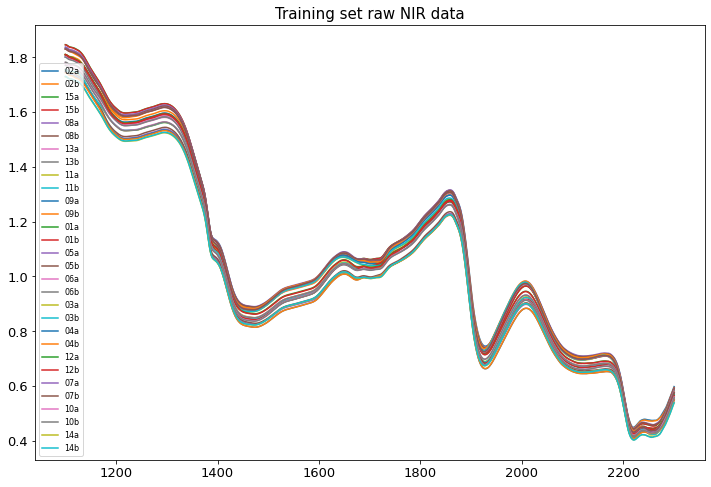

In [31]:
plt.figure(figsize=(12,8))
rows = X_train.index
for i in rows:
  plt.plot(range(1100,2301,1),X_train.loc[i],label=i)
plt.legend(fontsize=8, loc="best")
plt.title('Training set raw NIR data',fontsize = 15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

> B. Pre-process the NIR data and perform PCA for 5 components.

In [32]:
#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [34]:
#perform PCA with 5PCs
pca = PCA(n_components=5, svd_solver='full')
pca_scores = pca.fit_transform(X_train_scaled)
# Extract the scores
scores_pd = pd.DataFrame(data = pca_scores, columns = ['PC1', 'PC2', 'PC3','PC4','PC5'], index = X_train.index)
# Extract the loadings
loadings_pd = pd.DataFrame(data = pca.components_.T, columns = ['PC1', 'PC2', 'PC3','PC4','PC5'], index = X_train.columns)

> C. Plot the cumulative explained variance versus the number of components. How many components do we need to capture 99% of the variance?

We need 3 components to capture 99% of the variance.

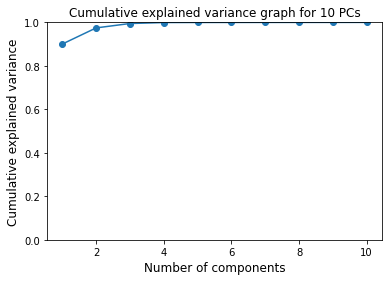

In [44]:
#plot the cumulative explained variance graph for 10 PCs
pca_10 = PCA(n_components=10, svd_solver='full')
pca_10.fit(X_train_scaled)
plt.plot(range(1,pca_10.n_components+1), np.cumsum(pca_10.explained_variance_ratio_),'-o')
plt.xlabel('Number of components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)
plt.title('Cumulative explained variance graph for 10 PCs')
plt.tick_params(labelsize=10)
plt.ylim(0,1)
plt.show()

In [42]:
for i in range(10):
  if sum(pca_10.explained_variance_ratio_[:i]) > 0.99:
    break
print(f"We need {i} components to capture 99% of the variance.")

We need 3 components to capture 99% of the variance.


> D. Plot the PCA scores for the first two components. **Comment on any outliers, trends, clusters etc (if any).**

There's no outliers because the data points clustered colse to each other. There is a cluster of data points 02a,02b,08a,08b,07a,07b,15a,15b.

In [52]:
def myplot(scores,loadings,loading_labels=None,score_labels=None):
    # adjusting the scores to fit in (-1,1)
    xt = scores[:,0]
    yt = scores[:,1]
    n = loadings.shape[0]
    scalext = 1.0/(xt.max() - xt.min())
    scaleyt = 1.0/(yt.max() - yt.min())
    xt_scaled = xt * scalext
    yt_scaled = yt * scaleyt

    for (x,y), label in zip(np.vstack((xt_scaled, yt_scaled)).T,score_labels):
        plt.text(x, y, label, ha='center', size=11)

    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1), fontsize=15);
    plt.ylabel("PC{}".format(2), fontsize=15);
    plt.tick_params(labelsize=12)
    plt.grid()

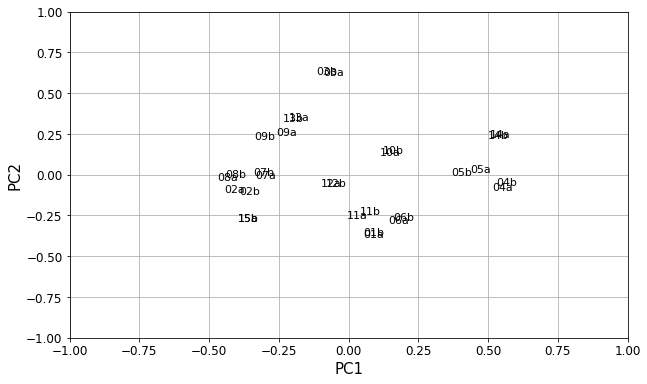

In [58]:
plt.rcParams["figure.figsize"] = [10,6]
myplot(pca_scores[:,:2],loadings_pd.iloc[:,:2],loading_labels=loadings_pd.index,score_labels=scores_pd.index)
plt.show()

>E. Plot the loadings of the first two components and comment on which wavelengths seem to be important for different PCs. **Don't** describe the graphs in words. In two sentences, describe any significant trends or signals (if any).

There's no important wavelength for PC1 because PC1 almost takes the same amount for every wavelength in counts. The wavelengths from 1146 to 1150nm are important to PC2.

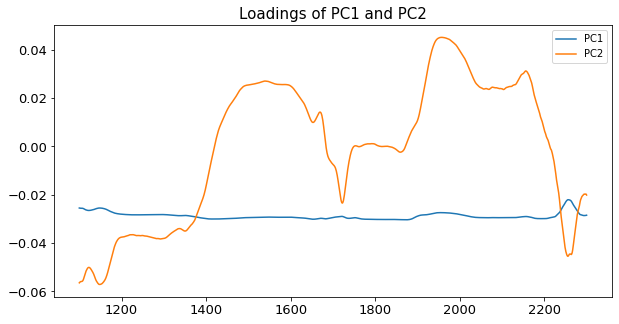

In [72]:
loadings_2 = loadings_pd.iloc[:,:2]
plt.figure(figsize=(10,5))
cols = loadings_2.columns
for i in cols:
  plt.plot(range(1100,2301,1),loadings_2[i],label=i)
plt.legend(fontsize=10, loc="best")
plt.title('Loadings of PC1 and PC2',fontsize = 15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [78]:
print(f"The wavelength that is important to PC2 is {loadings_2.index[np.argmax(abs(loadings_2['PC2']))]}.")

The wavelength that is important to PC2 is w1148.


> F. Apply the dimensionality reduction with the PCA model you developed in step B for the **test set** using the **transform** method.

In [79]:
test = pd.read_excel('sawdust_pred.xlsx')
#drop "Primary ID" and reindex
test = test.drop(['Primary ID'], axis = 1)
test.set_index("OBSNAM", inplace=True)
#split Y_test from train
Y_test = test.iloc[:,-3:]
#get X_test
X_test = test.iloc[:,:-3]
#Standardize data (only transform)
X_test_scaled = scaler.transform(X_test)
new_pca_scores = pca.transform(X_test_scaled)
#Extract the scores
new_scores_pd = pd.DataFrame(data = new_pca_scores, columns = ['PC1', 'PC2', 'PC3','PC4','PC5'], index = X_test.index)
#Loadings remain the same

> G. Create a scatter plot of the scores in PC1, PC2 of all 54 points in the train and test data set, coloured by the set they belong to (suggestion: use sns.scatterplot). Why is it important to overlap the scores of both train and test set in one graph? What are you checking to see?

Because it can help us better determine outliers and view if the testset is biased. If the data form test set are clustered and far away from the data in train set, then the model generated from training set can't capture the realation of data in test set. 

As shown in the graph, the test set is unbiased and can be used to measure the training performance.

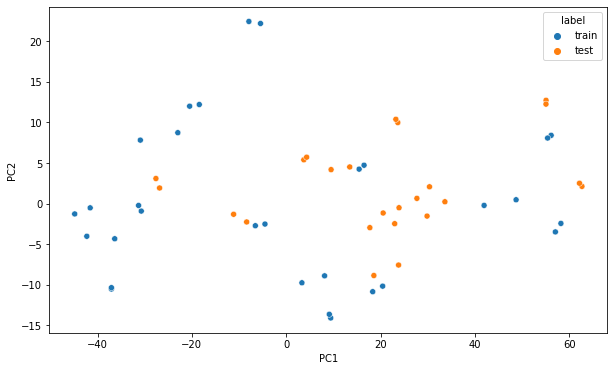

In [87]:
scores_pd['label'] = 'train'
new_scores_pd['label'] = 'test'
scores = pd.concat([scores_pd, new_scores_pd],axis = 0)
sns.scatterplot(data=scores, x="PC1", y="PC2", hue="label")

## 3.3 Task 2: Supervised learning, PLS model
> A. Run the PLS regression to model all 3 outputs with the scaled train set spectra. Increase the number of components to achieve R2 value of at least 0.92 (use PLSRegression's method score to estimate R2).

> B. Predict the output values for the inputs in the test set and compare them by plotting the 24 actual vs predicted values in a 1x3 subplot (for spruce, pine and birch, respectively). Also, include the y=x line for reference.